# Develop semantic input to phonology formula

## Plaut 96
<font size="5">$$
S = \frac{g * (log(f+2) * t)}{(log(f+2) * t +k)}...(1)
$$</font>

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


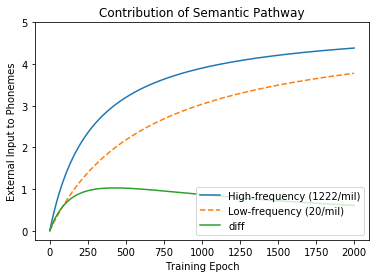

In [35]:
%load_ext lab_black
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def inputs_v1(t, f, g=5, k=2000):
    # Plaut 96
    numer = g * np.log(f + 2) * t
    denom = np.log(f + 2) * t + k
    return numer / denom


# Sanity check Plaut96 fig.21
t = range(2000)
s_high = [inputs_v1(x, 1222) for x in t]
s_low = [inputs_v1(x, 20) for x in t]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
line1, = ax.plot(t, s_high, label='High-frequency (1222/mil)')
line2, = ax.plot(t, s_low, label='Low-frequency (20/mil)', linestyle='dashed')
line3, = ax.plot(t, np.array(s_high) - np.array(s_low), label='diff')
ax.legend(loc='lower right')
ax.set_title('Contribution of Semantic Pathway')
ax.set_xlabel('Training Epoch')
ax.set_ylabel('External Input to Phonemes')
plt.ylim(top=5)
plt.show()

In [36]:
inputs_v1(2000, 20, 5, 2000)

3.7778176205686833

## Eval V1 formula
- Try to plot the formula as is, using our model setting (epoch, f by condition in strain data set)

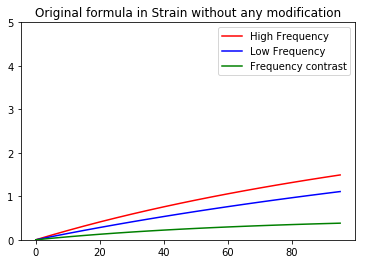

In [37]:
def epoch_plot_v1(e, g, k, hi_freq, lo_freq, title):
    # t is epoch in v1 equation
    a = inputs_v1(t=e, f=hi_freq, g=g, k=k)
    b = inputs_v1(t=e, f=lo_freq, g=g, k=k)

    con_f = a - b
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    line1 = ax.plot(e, a, color='r', label='High Frequency')
    line2 = ax.plot(e, b, color='b', label='Low Frequency')
    line3 = ax.plot(e, con_f, color='g', label='Frequency contrast')
    plt.ylim((0, 5))
    ax.legend()
    plt.show()


epoch_plot_v1(
    e=np.arange(0, 100, 5),
    g=5,
    k=2000,
    hi_freq=7700,
    lo_freq=402,
    title="Original formula in Strain without any modification"
)

- It is quite differnt from Plaut paper, try to fix it by changing k

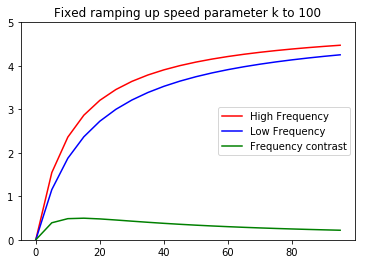

In [38]:
epoch_plot_v1(
    e=np.arange(0, 100, 5),
    g=5,
    k=100,
    hi_freq=7700,
    lo_freq=402,
    title="Fixed ramping up speed parameter k to 100"
)

### We now have a general shape to aim for
- from the equation, we knows k is determining the ramp-up speed
- and g is determining the asymtoptic value of S 

## Major requirements
- Need time in the equation, in both developmental sense (epoch, e from now on) and time step (unit time, t from now on)
    - The progression of development should generally follow Plaut equation
    - The progression of time step should be more or less linear
- Need imageability (i from now on) in the same equation
- Match f & i scaling by z normalization
- Equation will takes all raw input and handle everything within the formula

### Considering all these, we get:

<font size="5">$$
S = \frac{t}{t_{max}} [ g_f (\frac{e * (z_f + h_f)^{m_f}}{e * (z_f + h_f)^{m_f} + k_f}) + 
g_i(\frac{e * (z_i + h_i)^{m_i}}{e * (z_i + h_i)^{m_i} +k_i})]
$$</font>

where,

<font size="3">$$z_f = \frac{ log(f+2) - \bar \log (f+2)} {\sigma_{\log(f+2)}}...(3)$$</font>

<font size="3">$$z_i = \frac{ i -\bar{i}}{\sigma_i}...(4)$$</font>


In formula (2)
- $S$ is the semantic input to P
- $t$: time step (in unit time scale)
- $t_{max}$: maximum time step for anchoring end time to epoch dimension…
- $g_f$, $g_i$: Magnitude output scaling factor for $f$ and $i$
- $k_f$, $k_i$: Speed of ramping speed scaling factor for $f$ and $i$
- $e$: epoch (10k samples in our current model)
- $h_f$, $h_i$: are for pushing the $z$ score above zero, 
- increase $h$ and $k$ together will reduce the differences between $S$ from high end and low end of the main effect (from $f$ or $i$)
- $z_f$ is the z-score of $\log{(f+2)}$, see formula (3)
    - $ \bar \log (f+2) $ is the mean of log(f+2) in the training set
    - $ \sigma_{\log(f+2)} $ is the SD of log(f+2) in the training set
- $z_i$ is the z-score of $i$, see formula (4)
    - $ \bar i $ is the mean of i in the training set
    - $ \sigma_i $ is the SD of i in the training set


### Consolidate everthing into a class

In [39]:
import pandas as pd
df_strain = pd.read_csv('../../common/input/df_strain.csv', index_col=0)
df_strain.groupby(['frequency', 'imageability'])['wf', 'img'].mean()

wf       img
frequency imageability                    
HF        HI            6443.925  6.009909
          LI            8956.975  3.582470
LF        HI             293.475  6.252500
          LI             510.225  3.657500

In [40]:
class S:
    def __init__(self, cfg, max_epoch):

        self.cfg = cfg
        self.gf = self.cfg.sem_param_gf
        self.gi = self.cfg.sem_param_gi
        self.kf = self.cfg.sem_param_kf
        self.ki = self.cfg.sem_param_ki
        self.hf = self.cfg.sem_param_hf
        self.hi = self.cfg.sem_param_hi
        self.max_epoch = max_epoch

        self.df_train = pd.read_csv(
            '../../common/input/df_train.csv', index_col=0
        )
        self.df_strain = pd.read_csv(
            '../../common/input/df_strain.csv', index_col=0
        )

        # Assume perfectly balanced
        self.hi_freq = self.df_strain.groupby('frequency')['wf'].mean().HF
        self.lo_freq = self.df_strain.groupby('frequency')['wf'].mean().LF
        self.hi_img = self.df_strain.groupby('imageability')['img'].mean().HI
        self.lo_img = self.df_strain.groupby('imageability')['img'].mean().LI

        # Actual quadrant
        self.hfhi = [6443.925, 6.009909]
        self.hfli = [8956.975, 3.582470]
        self.lfhi = [293.475, 6.252500]
        self.lfli = [510.225, 3.657500]

        self.e = np.arange(0, 501, 5)
        self.t = self.cfg.unit_time - self.cfg.tau

        self.lwf_train = np.log(self.df_train.wf + 2)
        self.img_train = self.df_train.img
        self.mf = self.lwf_train.mean()
        self.sf = self.lwf_train.std()
        self.mi = self.img_train.mean()
        self.si = self.img_train.std()


#         print('M (SD) in train set: log(f+2) = {} ({}), img = {} ({})'.format(self.mf, self.sf, self.mi, self.si))
#         print('In strain: High frequency = {}, Low frequency = {}, high imageability = {}, low imageability = {} \n'.format(self.hi_freq, self.lo_freq, self.hi_img, self.lo_img))
#         self.print_strain_z()

    def input_s_plaut(t, f, g=5, k=2000):
        # Plaut 96
        numer = g * np.log(f + 2) * t
        denom = np.log(f + 1) * t + k
        return numer / denom

    def print_strain_z(self):
        # Print actual z-value in all 4 quadrants
        fs = self.hfhi[0], self.hfli[0], self.lfhi[0], self.lfli[0]
        imgs = self.hfhi[1], self.hfli[1], self.lfhi[1], self.lfli[1]

        z_fs = (np.log(np.array(fs)) - self.mf) / self.sf
        z_imgs = (np.array(imgs) - self.mi) / self.si

        print(
            'z-value in high frequency, high img = {0:6.2f}, {1:6.2f} \n'.
            format(z_fs[0], z_imgs[0])
        )
        print(
            'z-value in high frequency, low img = {0:6.2f}, {1:6.2f} \n'.format(
                z_fs[1], z_imgs[1]
            )
        )
        print(
            'z-value in low frequency, high img = {0:6.2f}, {1:6.2f} \n'.format(
                z_fs[2], z_imgs[2]
            )
        )
        print(
            'z-value in low frequency, low img = {0:6.2f}, {1:6.2f} \n'.format(
                z_fs[3], z_imgs[3]
            )
        )

    def cal_input(self, epoch, f, i):
        # TAI mechanism
        # Tau is from cfg file
        input_p = []
        input_p.append(0)

        for time in range(self.cfg.n_timesteps):
            mem_p = input_p[time]
            sp = self.input_s(
                epoch, time * self.cfg.tau, f, i, self.gf, self.gi, self.kf,
                self.ki, 3.8, self.mf, self.sf, self.mi, self.si, self.hf,
                self.hi
            )
            input_p.append(self.cfg.tau * sp + (1 - self.cfg.tau) * mem_p)

        return input_p

    def cal_strain(self, epoch):
        # Calculate mean p_input in each Strain condition
        self.input_hfhi = self.cal_input(epoch, self.hfhi[0], self.hfhi[1])
        self.input_hfli = self.cal_input(epoch, self.hfli[0], self.hfli[1])
        self.input_lfhi = self.cal_input(epoch, self.lfhi[0], self.lfhi[1])
        self.input_lfli = self.cal_input(epoch, self.lfli[0], self.lfli[1])

    def cal_all_strain_epoch(self):
        self.input_by_epo_hfhi = []
        self.input_by_epo_hfli = []
        self.input_by_epo_lfhi = []
        self.input_by_epo_lfli = []

        for epo in range(self.max_epoch):
            self.cal_strain(epo + 1)
            self.input_by_epo_hfhi.append(self.input_hfhi[-1])
            self.input_by_epo_hfli.append(self.input_hfli[-1])
            self.input_by_epo_lfhi.append(self.input_lfhi[-1])
            self.input_by_epo_lfli.append(self.input_lfli[-1])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.array(x)))

    def vio_plot(self):
        zlwf = (self.lwf_train - self.mf) / self.sf
        zi = (self.img_train - self.mi) / self.si

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.violinplot(
            [self.lwf_train, self.img_train, zlwf, zi], showmeans=True
        )
        plt.setp(
            ax,
            xticks=range(1, 5),
            xticklabels=['log_wf', 'img', 'z_log_wf', 'z_img']
        )
        plt.show()

    def get_train_percentile(self):
        pc = pd.DataFrame()
        import scipy.stats as st
        x = st.norm.ppf(np.arange(0.1, 0.9, 0.2))
        pc['wf'] = np.exp(x * self.sf + self.mf) - 2
        pc['img'] = x * self.si + self.mi
        return pc

    def get_train_quantile(self):
        qt = self.df_train.quantile(np.arange(0, 1, 0.2))
        return qt

    def eval_train(self, mode='pc'):
        # No TAI
        def short_input_s(e, t, f, i):
            return self.input_s(
                e,
                t,
                f,
                i,
                gf=self.gf,
                gi=self.gi,
                kf=self.kf,
                ki=self.ki,
                tmax=self.t,
                mf=self.mf,
                sf=self.sf,
                mi=self.mi,
                si=self.si,
                hf=self.hf,
                hi=self.hi
            )

        if mode == 'pc':
            plot_data = self.get_train_percentile()
        elif mode == 'qt':
            plot_data = self.get_train_quantile()
        else:
            print('No such mode, only pc or qt')

        fig = plt.figure(figsize=(24, 10))

        for i, wf in enumerate(plot_data.wf):
            ax = fig.add_subplot(2, 5, i + 1)
            for j, img in enumerate(plot_data.img):
                ax.plot(
                    self.e,
                    short_input_s(self.e, self.t, wf, img),
                    label='WF={0:.2f}, IMG={1:.2f}'.format(wf, img)
                )
                plt.ylim((0, 5))
                ax.legend()

        for i, img in enumerate(plot_data.img):
            ax = fig.add_subplot(2, 5, i + 6)
            for j, wf in enumerate(plot_data.wf):
                ax.plot(
                    self.e,
                    short_input_s(self.e, self.t, wf, img),
                    label='WF={0:.2f}, IMG={1:.2f}'.format(wf, img)
                )
                plt.ylim((0, 5))
                ax.legend()

        plt.show()

    def eval_strain(self):
        # No TAI
        def short_input_s(e, t, f, i):
            return self.input_s(
                e,
                t,
                f,
                i,
                gf=self.gf,
                gi=self.gi,
                kf=self.kf,
                ki=self.ki,
                tmax=self.t,
                mf=self.mf,
                sf=self.sf,
                mi=self.mi,
                si=self.si,
                hf=self.hf,
                hi=self.hi
            )

        # Plotting
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111)

        ea = short_input_s(self.e, self.t, self.hi_freq, self.hi_img)
        eb = short_input_s(self.e, self.t, self.hi_freq, self.lo_img)
        ec = short_input_s(self.e, self.t, self.lo_freq, self.hi_img)
        ed = short_input_s(self.e, self.t, self.lo_freq, self.lo_img)

        econ_f = ea + eb - ec - ed  # Freq contrast
        econ_i = ea + ec - eb - ed  # Img contrast

        idx = [i for i, x in enumerate(self.e) if x == self.e[-1]][0]

        plt.title('Semantic input over epoch \n (at t = {})'.format(self.t))
        line1 = ax.plot(self.e, ea, color='r', label='High F & High Img')
        line2 = ax.plot(self.e, eb, color='m', label='High F & Low Img')
        line3 = ax.plot(self.e, ec, color='c', label='Low F & High Img')
        line4 = ax.plot(self.e, ed, color='b', label='Low F & Low Img')
        line5 = ax.plot(self.e, econ_f, color='g', label='Frequency contrast')
        line6 = ax.plot(
            self.e, econ_i, color='k', label='Imageability contrast'
        )
        plt.ylim((0, 5))
        ax.annotate(
            'At epoch {0} S= {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f}'.format(
                self.e[-1], ea[idx], eb[idx], ec[idx], ed[idx]
            ),
            xy=(0, 1),
            xytext=(0.3, 4.5),
            fontsize=15
        )
        ax.legend()
        plt.show()

    def plot_p_at_epoch(self, epoch):
        # TAI implemented

        self.cal_strain(epoch)

        fig = plt.figure(figsize=(15, 6))
        plt.suptitle('At epoch {}'.format(epoch), fontsize=16)

        ax = fig.add_subplot(121)
        plt.title('input_p')
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_hfhi),
            label='high f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_hfli),
            label='high f, low img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_lfhi),
            label='low f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_lfli),
            label='low f, low img'
        )
        plt.ylim((0, 5))
        ax.legend()

        ax = fig.add_subplot(122)
        plt.title('activation_p')
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_hfhi)),
            label='high f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_hfli)),
            label='high f, low img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_lfhi)),
            label='low f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_lfli)),
            label='low f, low img'
        )
        plt.ylim((0, 1))
        ax.legend()

    def plot_p_at_time(self, timestep):
        # TAI implemented

        self.cal_strain(epoch)

        fig = plt.figure(figsize=(15, 6))
        plt.suptitle('At epoch {}'.format(epoch), fontsize=16)

        ax = fig.add_subplot(121)
        plt.title('input_p')
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_hfhi),
            label='high f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_hfli),
            label='high f, low img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_lfhi),
            label='low f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.input_lfli),
            label='low f, low img'
        )
        plt.ylim((0, 5))
        ax.legend()

        ax = fig.add_subplot(122)
        plt.title('activation_p')
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_hfhi)),
            label='high f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_hfli)),
            label='high f, low img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_lfhi)),
            label='low f, high img'
        )
        ax.plot(
            np.arange(self.cfg.n_timesteps + 1),
            np.array(self.sigmoid(self.input_lfli)),
            label='low f, low img'
        )
        plt.ylim((0, 1))
        ax.legend()

    def plot_s_by_epoch(self):

        self.cal_all_strain_epoch()
        fig = plt.figure(figsize=(15, 6))
        plt.suptitle('At last time step with TAI', fontsize=16)

        ax = fig.add_subplot(121)
        plt.title('input_p')
        xs = np.arange(self.max_epoch)
        a = np.array(self.input_by_epo_hfhi)
        b = np.array(self.input_by_epo_hfli)
        c = np.array(self.input_by_epo_lfhi)
        d = np.array(self.input_by_epo_lfli)
        con_f = a + b - c - d
        con_i = a + c - b - d

        ax.plot(xs, a, label='high f, high img')
        ax.plot(xs, b, label='high f, low img')
        ax.plot(xs, c, label='low f, high img')
        ax.plot(xs, d, label='low f, low img')
        ax.plot(xs, con_f, label='contrast f')
        ax.plot(xs, con_i, label='contrast img')
        plt.ylim((0, 20))
        ax.legend()

        ax = fig.add_subplot(122)
        plt.title('activation_p')
        ax.plot(
            xs,
            np.array(self.sigmoid(self.input_by_epo_hfhi)),
            label='high f, high img'
        )
        ax.plot(
            xs,
            np.array(self.sigmoid(self.input_by_epo_hfli)),
            label='high f, low img'
        )
        ax.plot(
            xs,
            np.array(self.sigmoid(self.input_by_epo_lfhi)),
            label='low f, high img'
        )
        ax.plot(
            xs,
            np.array(self.sigmoid(self.input_by_epo_lfli)),
            label='low f, low img'
        )
        plt.ylim((0, 1))
        ax.legend()

    def input_s(
        self,
        e,
        t,
        f,
        i,
        gf,
        gi,
        kf,
        ki,
        tmax=3.8,
        mf=4.4743,
        sf=2.4578,
        mi=4.1988,
        si=1.0078,
        hf=5,
        hi=5
    ):
        # mf and sf in log scale
        # f in raw scale
        # Plaut formula modified...

        numer_e = gf * e
        denom_e = e + kf

        return (t / tmax) * ((numer_e / denom_e) + 0.1 * np.log(f + 2))

# Fresh start

<font size="5">$$
S = \frac{gt}{t_{max}} (\frac{e * log(f + 2)}{e * (log(f+2) + k}) ,g = 6.31, k = 100 ... (1)
$$</font>

<font size="5">$$
S = \frac{gt}{t_{max}} (\frac{\sqrt{e} * log(f + 2)}{\sqrt{e} * (log(f+2) + k}) ,g = 7, k = 20 ... (2)
$$</font>

<font size="5">$$
S = \frac{gt}{t_{max}} (\frac{e}{e + k} + w_flog(f + 2)) ,g = 7, k = 50, w_f = 0.1 ... (3)
$$</font>

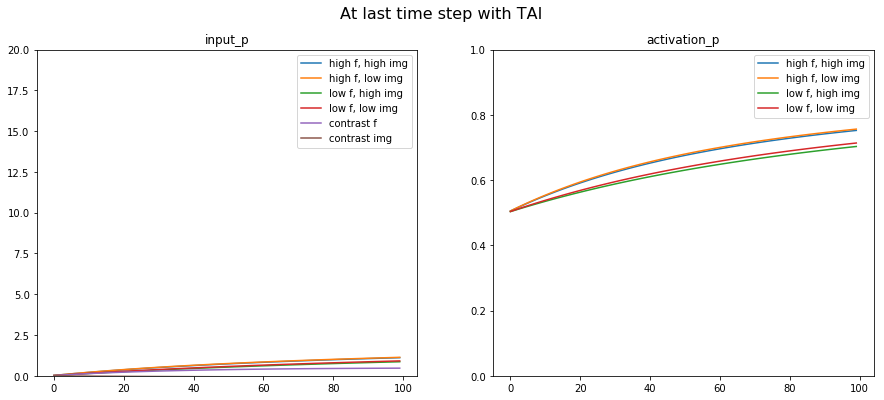

In [41]:
from meta import model_cfg


class refresh_v1(S):
    def input_s(
        self,
        e,
        t,
        f,
        i,
        gf,
        gi,
        kf,
        ki,
        tmax=3.8,
        mf=4.4743,
        sf=2.4578,
        mi=4.1988,
        si=1.0078,
        hf=0,
        hi=0
    ):
        # mf and sf in log scale
        # f in raw scale
        # Plaut formula modified...

        numer_f = gf * e * np.log(f + 2)
        denom_f = e * np.log(f + 2) + kf

        return (t / tmax) * (numer_f / denom_f)


cfg_v1 = model_cfg(
    sem_param_gf=3,
    sem_param_gi=0,
    sem_param_kf=1000.,
    sem_param_ki=0.,
    sem_param_hf=0.,
    sem_param_hi=0.
)

v1 = refresh_v1(cfg_v1, 100)
v1.plot_s_by_epoch()

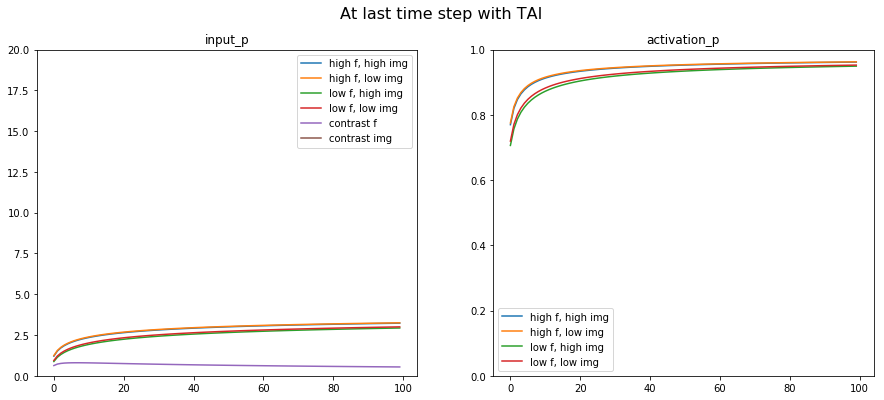

In [42]:
class refresh_v2(S):
    def input_s(
        self,
        e,
        t,
        f,
        i,
        gf,
        gi,
        kf,
        ki,
        tmax=3.8,
        mf=4.4743,
        sf=2.4578,
        mi=4.1988,
        si=1.0078,
        hf=5,
        hi=5
    ):
        # mf and sf in log scale
        # f in raw scale
        # Plaut formula modified...

        numer_f = gf * np.sqrt(e) * np.log(f + 2)
        denom_f = np.sqrt(e) * np.log(f + 2) + kf

        return (t / tmax) * (numer_f / denom_f)


cfg_v2 = model_cfg(
    sem_param_gf=5,
    sem_param_gi=0,
    sem_param_kf=20.,
    sem_param_ki=0.,
    sem_param_hf=0.,
    sem_param_hi=0.
)

v2 = refresh_v2(cfg_v2, 100)
v2.plot_s_by_epoch()

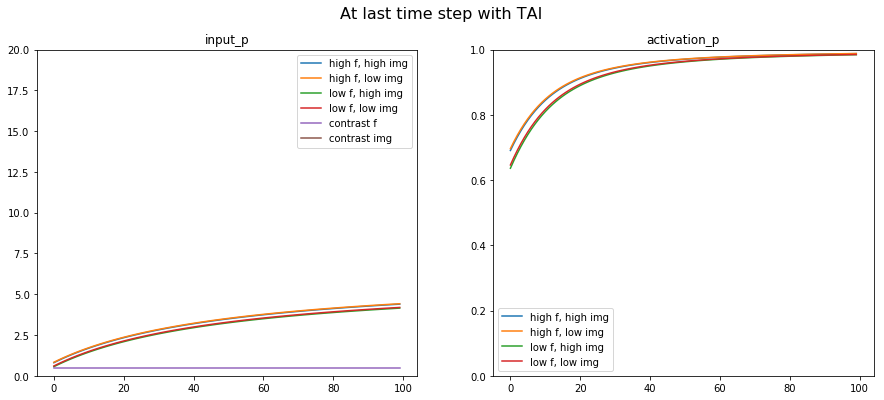

In [43]:
class refresh_v3(S):
    def input_s(
        self,
        e,
        t,
        f,
        i,
        gf,
        gi,
        kf,
        ki,
        tmax=3.8,
        mf=4.4743,
        sf=2.4578,
        mi=4.1988,
        si=1.0078,
        hf=5,
        hi=5
    ):

        numer_e = gf * e
        denom_e = e + kf

        return (t / tmax) * ((numer_e / denom_e) + 0.1 * np.log(f + 2))


cfg_v3 = model_cfg(
    sem_param_gf=7,
    sem_param_gi=0,
    sem_param_kf=50.,
    sem_param_ki=0.,
    sem_param_hf=0.,
    sem_param_hi=0.
)

v3 = refresh_v3(cfg_v3, 100)
v3.plot_s_by_epoch()

- In the original Plaut equation, the asymtopic value is roughtly 3.5 to 4.5 depending on the word frequency
- Because of TAI, the asymtoptic value decrease (e.g., let say we only have two time steps, set, tau=0.2, TAI defines integrated $input^{<t>} = 0.8 * input^{<t-1>} + 0.2 * input^{<t>}$
    - Since input t-1 < input t, therfore the integrated input < pure input<t> in the Plaut equation
    - i.e., TAI decrease the effective asymtoptic value k

# Slow down and reduce magnitude of semantic 

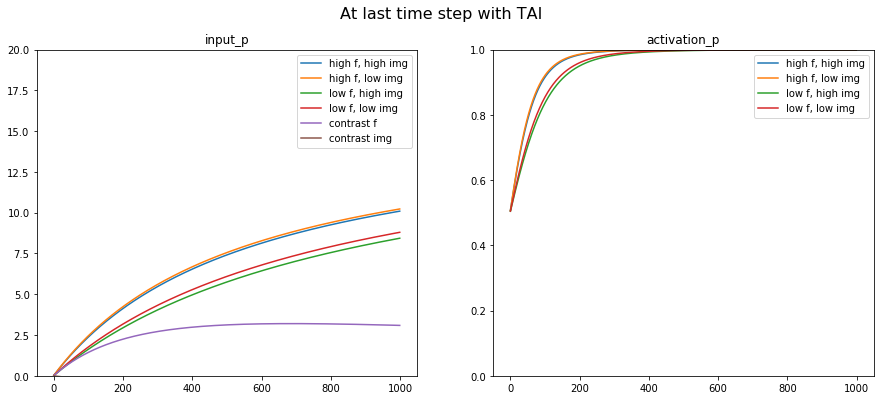

In [44]:
from meta import model_cfg


class testing(S):
    def input_s(
        self,
        e,
        t,
        f,
        i,
        gf,
        gi,
        kf,
        ki,
        tmax=3.8,
        mf=4.4743,
        sf=2.4578,
        mi=4.1988,
        si=1.0078,
        hf=0,
        hi=0
    ):
        numer_f = gf * e * np.log(f + 2)
        denom_f = e * np.log(f + 2) + kf
        return (t / tmax) * (numer_f / denom_f)


cfg_new = model_cfg(
    sem_param_gf=20,
    sem_param_gi=0,
    sem_param_kf=5000.,
    sem_param_ki=0.,
    sem_param_hf=0.,
    sem_param_hi=0.
)

x = testing(cfg_new, 1000)
x.plot_s_by_epoch()

In [45]:
!jupyter nbconvert --to html --output-dir='.' input_s_np.ipynb

[NbConvertApp] Converting notebook input_s_np.ipynb to html
[NbConvertApp] Writing 659147 bytes to ./input_s_np.html
